In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, random_split
#from networks import Model
#from dropout import *

from data import generate_data
#from train import train_main_model, train_deup
#from utils import inv_sigmoid, evaluate_and_plot, eval_error

import itertools

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def running_mean(x, N=100):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

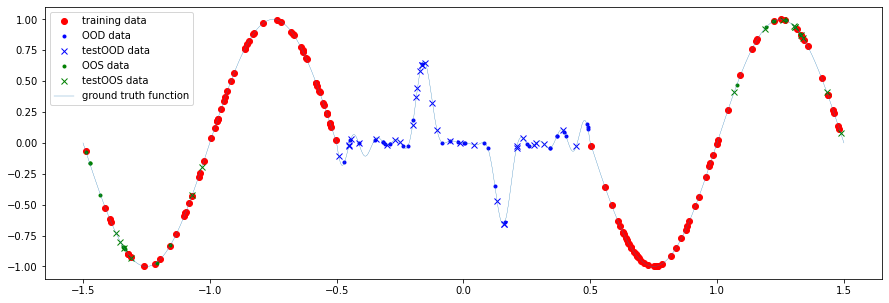

In [32]:
(x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test,
 oos_y_test, ood_x_test, ood_y_test, x_test, y_test) = generate_data(128, 32, 64, seed=7, plot=True, device=device, shuffle=True)

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

In [33]:
class main_net(nn.Module):
    def __init__(self, input_dim=1, width=128, n_hidden=2):
        super().__init__()
        self.x_layer = nn.Linear(input_dim, width)
        self.hiddens = nn.ModuleList([nn.Linear(width, width) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(width, 1)
    
    def forward(self, x):
        out = F.relu(self.x_layer(x))
        for i, l in enumerate(self.hiddens):
            out = F.relu(l(out))
        return self.output_layer(out)

In [34]:
LR = 3e-4
EPOCHS = 500
BS = 16
loss_fn = nn.MSELoss()

mu = main_net().to(device=device)
optimizer = torch.optim.Adam(mu.parameters(), lr=LR)
loader = DataLoader(TensorDataset(x, y), batch_size=BS)

In [35]:
losses = []
for epoch in range(EPOCHS):
    if epoch % 50 == 0:
        print('epoch {}'.format(epoch))
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(loader):
        optimizer.zero_grad()
        pred = mu(xi)
        loss = loss_fn(pred, yi)
        epoch_losses.append(loss.item() * xi.shape[0])
        loss.backward()
        optimizer.step()
    losses.append(np.sum(epoch_losses) / x.shape[0])

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
epoch 300
epoch 350
epoch 400
epoch 450


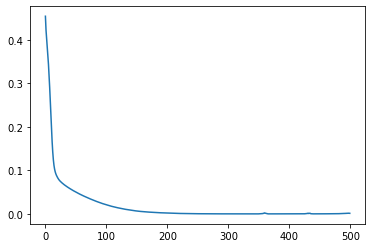

In [36]:
plt.plot(losses)
plt.show()

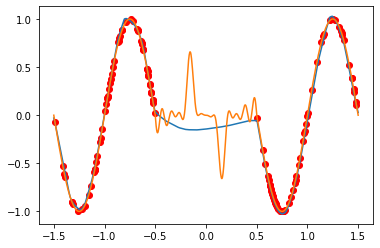

In [37]:
plt.plot(x.cpu(), y.cpu(), 'ro')
plt.plot(x_test.cpu(), mu(x_test).detach().cpu(), label='predictions')
plt.plot(x_test.cpu(), y_test.cpu(), label='true')
plt.show()

## Sanity check, what network architecture is needed to learn to regress the whole dataset

In [38]:
LR = 3e-6
EPOCHS = 6000
BS = 32
loss_fn = nn.MSELoss()

mu2 = main_net(n_hidden=4, width=512).to(device=device)
optimizer2 = torch.optim.Adam(mu2.parameters(), lr=LR)
f_loader = DataLoader(TensorDataset(full_X, full_Y),
                      shuffle=True,
                      batch_size=BS)

losses = []
for epoch in range(EPOCHS):
    if epoch % 50 == 0:
        print('epoch {}'.format(epoch))
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(f_loader):
        optimizer.zero_grad()
        pred = mu2(xi)
        loss = loss_fn(pred, yi)
        epoch_losses.append(loss.item() * xi.shape[0])
        loss.backward()
        optimizer2.step()
    losses.append(np.sum(epoch_losses) / x.shape[0])


epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
epoch 300
epoch 350
epoch 400
epoch 450
epoch 500
epoch 550
epoch 600
epoch 650
epoch 700
epoch 750
epoch 800
epoch 850
epoch 900
epoch 950
epoch 1000
epoch 1050
epoch 1100
epoch 1150
epoch 1200
epoch 1250
epoch 1300
epoch 1350
epoch 1400
epoch 1450
epoch 1500
epoch 1550
epoch 1600
epoch 1650
epoch 1700
epoch 1750
epoch 1800
epoch 1850
epoch 1900
epoch 1950
epoch 2000
epoch 2050
epoch 2100
epoch 2150
epoch 2200
epoch 2250
epoch 2300
epoch 2350
epoch 2400
epoch 2450
epoch 2500
epoch 2550
epoch 2600
epoch 2650
epoch 2700
epoch 2750
epoch 2800
epoch 2850
epoch 2900
epoch 2950
epoch 3000
epoch 3050
epoch 3100
epoch 3150
epoch 3200
epoch 3250
epoch 3300
epoch 3350
epoch 3400
epoch 3450
epoch 3500
epoch 3550
epoch 3600
epoch 3650
epoch 3700
epoch 3750
epoch 3800
epoch 3850
epoch 3900
epoch 3950
epoch 4000
epoch 4050
epoch 4100
epoch 4150
epoch 4200
epoch 4250
epoch 4300
epoch 4350
epoch 4400
epoch 4450
epoch 4500
epoch 4550
epoch 4600


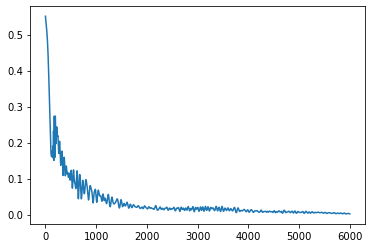

In [39]:
plt.plot(losses)
plt.show()

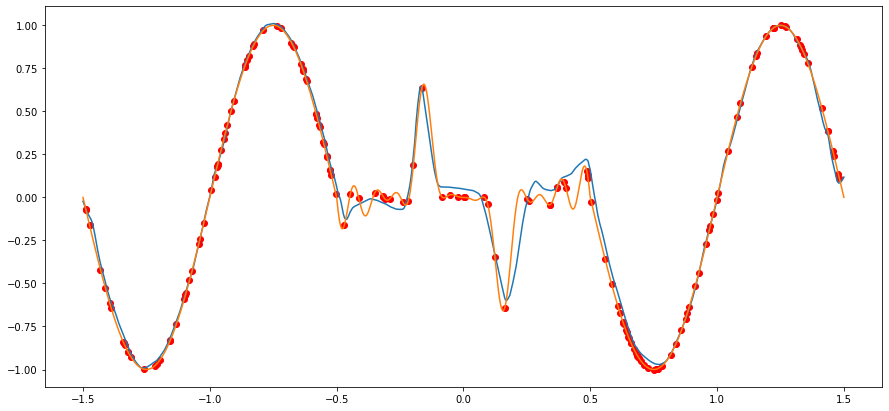

In [40]:
plt.figure(figsize=(15, 7))
plt.plot(full_X.cpu(), full_Y.cpu(), 'ro')
plt.plot(x_test.cpu(), mu2(x_test).detach().cpu(), label='predictions')
plt.plot(x_test.cpu(), y_test.cpu(), label='true')
plt.show()

## Same as below but random values for each x (no phi network)

In [51]:
class full_net(nn.Module):
    def __init__(self, input_dim=1, noise_dim=16, width=256, n_hidden=3):
        super().__init__()
        self.n_hidden = n_hidden
        self.noise_dim = noise_dim
        self.x_layer = nn.Linear(input_dim + noise_dim, width)
        self.hiddens = nn.ModuleList([nn.Linear(width, width) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(width, 1)
    
    def forward(self, x, z=None):
        if z is None:
            z = torch.zeros(x.shape[0], self.noise_dim).to(x.device)
        out = F.relu(self.x_layer(torch.cat([x, z], 1)))
        for i, l in enumerate(self.hiddens):
            out = F.relu(l(out))
        return self.output_layer(out)
    

class phi_net(nn.Module):
    def __init__(self, full_X, noise_dim=16):
        super().__init__()
        rand_dict = {tuple(xx.cpu().numpy()): torch.randn(noise_dim).to(device=device) for xx in full_X}
        for k in rand_dict.keys():
            rand_dict[k] /= torch.norm(rand_dict[k])
        self.rand_dict = rand_dict
    
    def forward(self, x):
        # x should be a B x d tensor
        return torch.cat([self.rand_dict[tuple(xx.cpu().numpy())].unsqueeze(0) for xx in x])

In [52]:
NOISE_DIM = 5
LR2 = 3e-6
EPOCHS2 = 8000
BS2 = 8
GAMMA = .1
N_HIDDEN = 6

emb = phi_net(full_X, NOISE_DIM).to(device=device)
f = full_net(noise_dim=NOISE_DIM, width=512, n_hidden=N_HIDDEN).to(device=device)
f_optimizer = torch.optim.Adam(f.parameters(), lr=LR2)
f_loader = DataLoader(TensorDataset(full_X, full_Y),
                      shuffle=True,
                      batch_size=BS2)


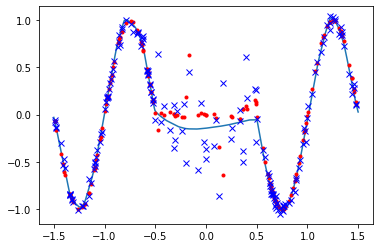

In [53]:
# what does the dreamed data for a random z looks like ?
z = (torch.randn(NOISE_DIM)).to(device=device)
plt.plot(x_test.cpu(), mu(x_test).detach().cpu())
plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='true')
plt.plot(full_X.cpu(), (mu(full_X) + (emb(full_X)@z).unsqueeze(-1) * (full_Y - mu(full_X))).detach().cpu(), 'bx', label='dreamed')

In [54]:
f_losses = []
f_losses_0 = []
for epoch in range(EPOCHS2):
    epoch_losses = []
    epoch_losses_0 = []
    if epoch % 500 == 0:
        print('epoch {}'.format(epoch))        
    for batch_id, (xi, yi) in enumerate(f_loader):
        z = torch.randn(NOISE_DIM).to(device=device)
        z_batched = z.repeat(xi.shape[0], 1) 
        f_optimizer.zero_grad()
        pred = mu(xi)
        residuals = (yi - pred)
        with torch.no_grad():
            noisei = (emb(xi)@z).unsqueeze(-1)  # B x 1
        dreamed_data = pred + noisei * residuals
        loss = loss_fn(f(xi, z_batched), dreamed_data)

        z_0 = torch.zeros(xi.shape[0], NOISE_DIM).to(device=device)
        loss_0 = loss_fn(f(xi, z_0), pred)

        epoch_losses.append(loss.item() * xi.shape[0])
        epoch_losses_0.append(loss_0.item() * xi.shape[0])

        total_loss = loss + GAMMA * loss_0

        total_loss.backward()
        f_optimizer.step()
    f_losses.append(np.sum(epoch_losses) / x.shape[0])
    f_losses_0.append(np.sum(epoch_losses_0) / x.shape[0])


epoch 0
epoch 500
epoch 1000
epoch 1500
epoch 2000
epoch 2500
epoch 3000
epoch 3500
epoch 4000
epoch 4500
epoch 5000
epoch 5500
epoch 6000
epoch 6500
epoch 7000
epoch 7500


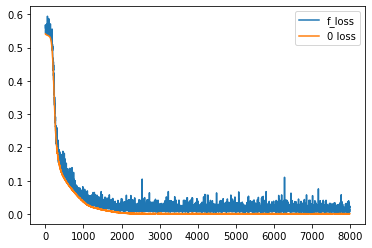

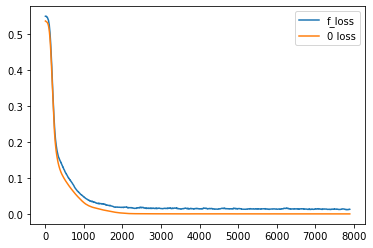

In [55]:
plt.plot(f_losses, label='f_loss')
plt.plot(f_losses_0, label='0 loss')
plt.legend()
plt.show()
plt.plot(running_mean(f_losses, N=100), label='f_loss')
plt.plot(running_mean(f_losses_0, N=100), label='0 loss')
plt.legend()
plt.show()

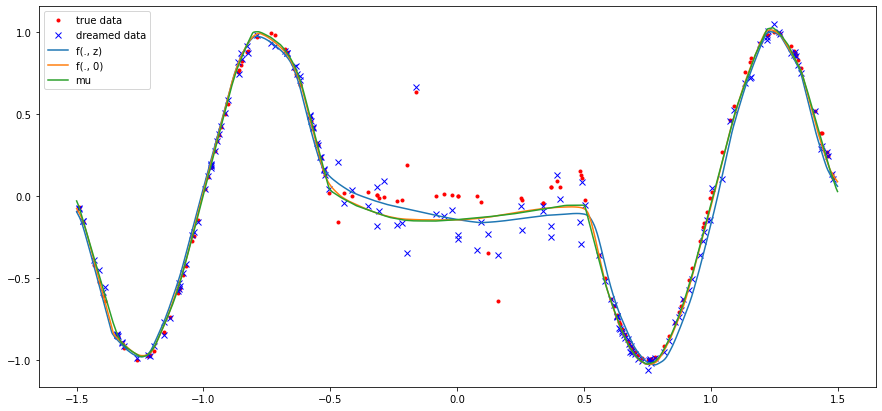

In [57]:
z = torch.randn(NOISE_DIM).to(device=device)

additive_noise = (emb(full_X)@z).unsqueeze(-1)

plt.figure(figsize=(15, 7))
plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='true data')
residuals = full_Y - mu(full_X)
dreamed_data = mu(full_X) + additive_noise * residuals
plt.plot(full_X.cpu(), dreamed_data.detach().cpu(), 'bx', label='dreamed data')
plt.plot(x_test.cpu(), (f(x_test, z.repeat(x_test.shape[0], 1))).detach().cpu(), label='f(., z)')
plt.plot(x_test.cpu(), (f(x_test)).detach().cpu(), label='f(., 0)')
plt.plot(x_test.cpu(), mu(x_test).detach().cpu(), label='mu')

plt.legend()
plt.show()

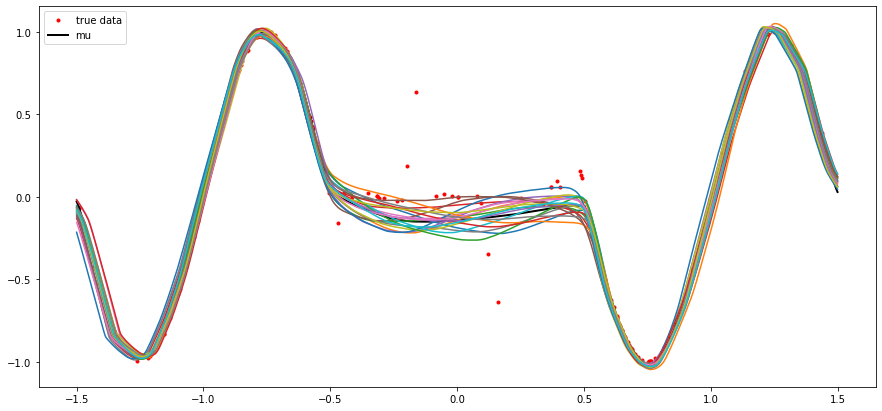

In [59]:
plt.figure(figsize=(15, 7))
plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='true data')
residuals = full_Y - mu(full_X)
plt.plot(x_test.cpu(), mu(x_test).detach().cpu(), 'k', label='mu', linewidth=2.0)

for _ in range(20):
    z = torch.randn(NOISE_DIM).to(device=device)
    plt.plot(x_test.cpu(), (f(x_test, z.repeat(x_test.shape[0], 1))).detach().cpu())

plt.legend()
plt.show()

## Fixed randomly initialized embeddings to define noise

In [189]:
class full_net(nn.Module):
    def __init__(self, input_dim=1, noise_dim=16, width=256, n_hidden=3):
        super().__init__()
        self.n_hidden = n_hidden
        self.noise_dim = noise_dim
        self.x_layer = nn.Linear(input_dim + noise_dim, width)
        self.hiddens = nn.ModuleList([nn.Linear(width, width) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(width, 1)
    
    def forward(self, x, z=None):
        if z is None:
            z = torch.zeros(x.shape[0], self.noise_dim).to(x.device)
        out = F.relu(self.x_layer(torch.cat([x, z], 1)))
        for i, l in enumerate(self.hiddens):
            out = F.relu(l(out))
        return self.output_layer(out)
    

class phi_net(nn.Module):
    def __init__(self, input_dim=1, output_dim=16, width=128):
        super().__init__()
        self.x_layer = nn.Linear(input_dim, width)
        self.hidden_layer = nn.Linear(width, width)
        self.output_layer = nn.Linear(width, output_dim)
        
    def forward(self, x):
        out = F.relu(self.x_layer(x))
        out = F.relu(self.hidden_layer(out))
        out = self.output_layer(out)
        return out / torch.norm(out, dim=1).unsqueeze(-1)

In [184]:
NOISE_DIM = 128
LR2 = 7e-4
EPOCHS2 = 7000
BS2 = 32
GAMMA = .1
N_HIDDEN = 5

emb = phi_net(output_dim=NOISE_DIM).to(device=device)
f = full_net(noise_dim=NOISE_DIM, width=512, n_hidden=N_HIDDEN).to(device=device)
f_optimizer = torch.optim.Adam(f.parameters(), lr=LR2)
f_loader = DataLoader(TensorDataset(full_X, full_Y),
                      shuffle=True,
                      batch_size=BS2)

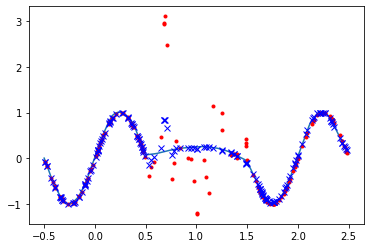

In [185]:
# what does the dreamed data for a random z looks like ?
z = (torch.randn(NOISE_DIM)).to(device=device)
plt.plot(x_test.cpu(), mu(x_test).detach().cpu())
plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='true')
plt.plot(full_X.cpu(), (mu(full_X) + (emb(full_X)@z).unsqueeze(-1) * (full_Y - mu(full_X))).detach().cpu(), 'bx', label='dreamed')

In [186]:
f_losses = []
f_losses_0 = []
for epoch in range(EPOCHS2):
    epoch_losses = []
    epoch_losses_0 = []
    if epoch % 500 == 0:
        print('epoch {}'.format(epoch))        
    for batch_id, (xi, yi) in enumerate(f_loader):
        z = torch.randn(NOISE_DIM).to(device=device)
        z_batched = z.repeat(xi.shape[0], 1) 
        f_optimizer.zero_grad()
        pred = mu(xi)
        residuals = (yi - pred)
        with torch.no_grad():
            noisei = (emb(xi)@z).unsqueeze(-1)  # B x 1
        dreamed_data = pred + noisei * residuals
        loss = loss_fn(f(xi, z_batched), dreamed_data)

        z_0 = torch.zeros(xi.shape[0], NOISE_DIM).to(device=device)
        loss_0 = loss_fn(f(xi, z_0), pred)

        epoch_losses.append(loss.item() * xi.shape[0])
        epoch_losses_0.append(loss_0.item() * xi.shape[0])

        total_loss = loss + GAMMA * loss_0

        total_loss.backward()
        f_optimizer.step()
    f_losses.append(np.sum(epoch_losses) / x.shape[0])
    f_losses_0.append(np.sum(epoch_losses_0) / x.shape[0])


epoch 0
epoch 500
epoch 1000
epoch 1500
epoch 2000
epoch 2500
epoch 3000
epoch 3500
epoch 4000
epoch 4500
epoch 5000
epoch 5500
epoch 6000
epoch 6500


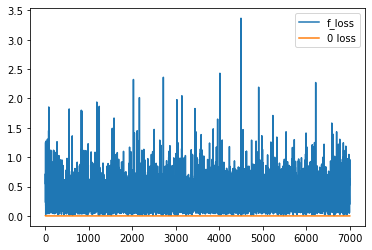

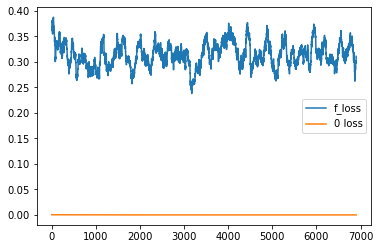

In [187]:
plt.plot(f_losses, label='f_loss')
plt.plot(f_losses_0, label='0 loss')
plt.legend()
plt.show()
plt.plot(running_mean(f_losses, N=100), label='f_loss')
plt.plot(running_mean(f_losses_0, N=100), label='0 loss')
plt.legend()
plt.show()


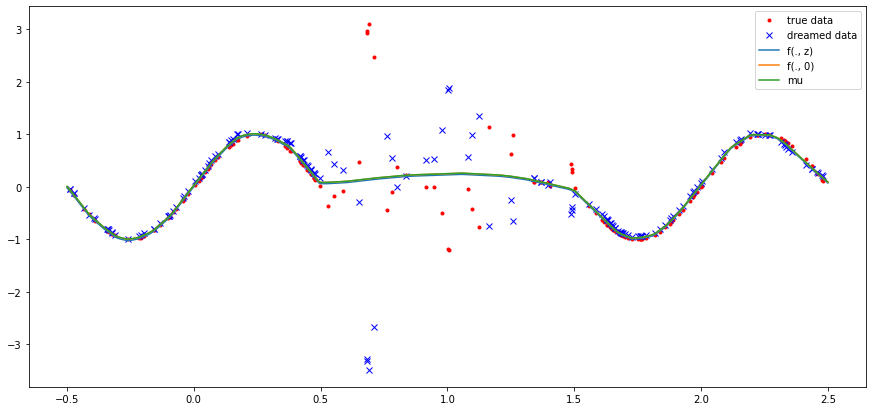

In [188]:
z = torch.randn(NOISE_DIM).to(device=device)

additive_noise = (emb(full_X)@z).unsqueeze(-1)

plt.figure(figsize=(15, 7))
plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='true data')
residuals = full_Y - mu(full_X)
dreamed_data = mu(full_X) + additive_noise * residuals
plt.plot(full_X.cpu(), dreamed_data.detach().cpu(), 'bx', label='dreamed data')
plt.plot(x_test.cpu(), (f(x_test, z.repeat(x_test.shape[0], 1)) + mu(x_test)).detach().cpu(), label='f(., z)')
plt.plot(x_test.cpu(), (f(x_test) + mu(x_test)).detach().cpu(), label='f(., 0)')
plt.plot(x_test.cpu(), mu(x_test).detach().cpu(), label='mu')

plt.legend()
plt.show()

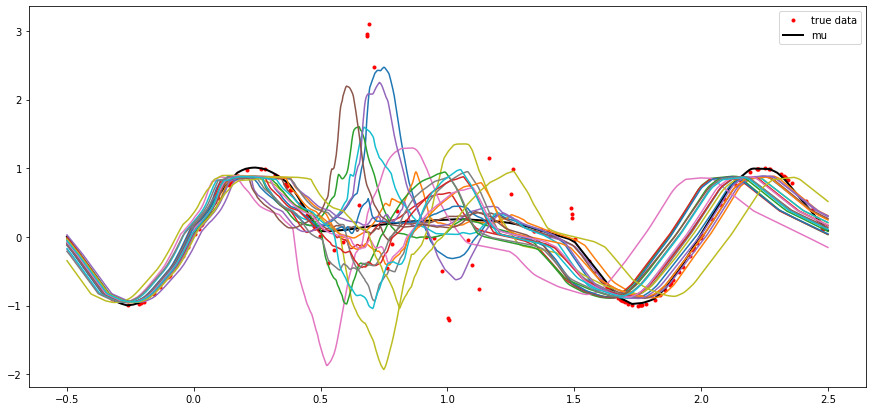

In [183]:
plt.figure(figsize=(15, 7))
plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='true data')
residuals = full_Y - mu(full_X)
plt.plot(x_test.cpu(), mu(x_test).detach().cpu(), 'k', label='mu', linewidth=2.0)

for _ in range(20):
    z = torch.randn(NOISE_DIM).to(device=device)
    plt.plot(x_test.cpu(), (f(x_test, z.repeat(x_test.shape[0], 1))).detach().cpu())

plt.legend()
plt.show()

## Making the z's match random variations of data

In [9]:
class full_net(nn.Module):
    def __init__(self, input_dim=1, noise_dim=16, width=256):
        super().__init__()
        self.noise_dim = noise_dim
        self.x_layer = nn.Linear(input_dim + noise_dim, width)
        self.hidden_layer_1 = nn.Linear(width, width)
        self.hidden_layer_2 = nn.Linear(width, width)
        self.hidden_layer_3 = nn.Linear(width, width)
        self.output_layer = nn.Linear(width, 1)
    
    def forward(self, x, z=None):
        if z is None:
            z = torch.zeros(x.shape[0], self.noise_dim).to(x.device)
        out = F.relu(self.x_layer(torch.cat([x, z], 1)))
        out = F.relu(self.hidden_layer_1(out))
        out = F.relu(self.hidden_layer_2(out))
        return self.output_layer(out)
    

In [20]:
NOISE_DIM = 128
LR2 = 1e-4
EPOCHS2 = 20
SUBEPOCHS = 500
BS2 = 32
EPSILON = 1e-6
GAMMA = .1

f = full_net(noise_dim=NOISE_DIM).to(device=device)
f_optimizer = torch.optim.Adam(f.parameters(), lr=LR2)
full_X = torch.cat([x, oos_x, ood_x])
full_Y = torch.cat([y, oos_y, ood_y])
f_loader = DataLoader(TensorDataset(full_X, full_Y),
                      shuffle=True,
                      batch_size=BS2)

In [ ]:
f_losses = []
f_losses_0 = []
training_zs = []
training_additive_noises = []
for epoch in range(EPOCHS2):
    print('epoch {}'.format(epoch))
    
    z = torch.randn(NOISE_DIM).to(device=device)
    training_zs.append(z)
    
    additive_noise = torch.randn_like(full_Y)
    training_additive_noises.append(additive_noise)
    
    epoch_loader = DataLoader(TensorDataset(full_X, full_Y, additive_noise),
                      shuffle=True,
                      batch_size=BS2)
    for sub_epoch in range(SUBEPOCHS):
        epoch_losses = []
        epoch_losses_0 = []
        for batch_id, (xi, yi, noisei) in enumerate(epoch_loader):
            z_batched = z.repeat(xi.shape[0], 1) 
            f_optimizer.zero_grad()
            pred = mu(xi)
            residuals = torch.clamp((yi - pred).abs(), min=EPSILON)
            dreamed_data = pred + noisei * residuals  # Adding a ~N(0, residual) to each prediction. Not sure it should be randn, maybe GP
            loss = loss_fn(f(xi, z_batched), dreamed_data)

            z_0 = torch.zeros(xi.shape[0], NOISE_DIM).to(device=device)
            loss_0 = loss_fn(f(xi, z_0), pred)

            epoch_losses.append(loss.item() * xi.shape[0])
            epoch_losses_0.append(loss_0.item() * xi.shape[0])

            total_loss = loss + GAMMA * loss_0

            total_loss.backward()
            f_optimizer.step()
        f_losses.append(np.sum(epoch_losses) / x.shape[0])
        f_losses_0.append(np.sum(epoch_losses_0) / x.shape[0])

In [ ]:
index = 17

additive_noise = training_additive_noises[index]
z = training_zs[index]

plt.figure(figsize=(15, 7))
plt.plot(full_X.cpu(), full_Y.cpu(), 'ro')
residuals = torch.clamp((full_Y - mu(full_X)).abs(), min=EPSILON)
dreamed_data = mu(full_X) + additive_noise * residuals
plt.plot(full_X.cpu(), dreamed_data.detach().cpu(), 'bx')
plt.plot(x_test.cpu(), f(x_test, z.repeat(x_test.shape[0], 1)).detach().cpu(), label='z={} used for training'.format(index))
plt.plot(x_test.cpu(), f(x_test).detach().cpu(), label='zero')

plt.legend()
plt.show()

## Using the OMEGA network


In [9]:
class full_net(nn.Module):
    def __init__(self, input_dim=1, noise_dim=16, width=256):
        super().__init__()
        self.noise_dim = noise_dim
        self.x_layer = nn.Linear(input_dim + noise_dim, width)
        self.hidden_layer_1 = nn.Linear(width, width)
        self.hidden_layer_2 = nn.Linear(width, width)
        self.hidden_layer_3 = nn.Linear(width, width)
        self.output_layer = nn.Linear(width, 1)
    
    def forward(self, x, z=None):
        if z is None:
            z = torch.zeros(x.shape[0], self.noise_dim).to(x.device)
        out = F.relu(self.x_layer(torch.cat([x, z], 1)))
        out = F.relu(self.hidden_layer_1(out))
        out = F.relu(self.hidden_layer_2(out))
        return self.output_layer(out)
    

class omega_net(nn.Module):
    def __init__(self, input_dim=1, output_dim=16, width=128):
        super().__init__()
        self.x_layer = nn.Linear(input_dim, width)
        self.hidden_layer = nn.Linear(width, width)
        self.output_layer = nn.Linear(width, output_dim)
        
    def forward(self, x):
        out = F.relu(self.x_layer(x))
        out = F.relu(self.hidden_layer(out))
        return self.output_layer(out)

In [10]:
NOISE_DIM = 128
LR2 = 3e-4
EPOCHS2 = 1000
BS2 = 32
GAMMA = .5
DELTA = 2.

f = full_net(noise_dim=NOISE_DIM).to(device=device)
o_net = omega_net(output_dim=NOISE_DIM).to(device=device)

f_optimizer = torch.optim.Adam(itertools.chain(f.parameters(), o_net.parameters()), lr=LR2)
full_X = torch.cat([x, oos_x, ood_x])
full_Y = torch.cat([y, oos_y, ood_y])
f_loader = DataLoader(TensorDataset(full_X, full_Y),
                      shuffle=True,
                      batch_size=BS2)

In [11]:
f_losses = []
f_losses_0 = []
f_losses_omega = []
for epoch in range(EPOCHS2):
    epoch_losses = []
    epoch_losses_0 = []
    epoch_losses_omega = []
    if epoch % 50 == 0:
        print('epoch {}'.format(epoch))        
    for batch_id, (xi, yi) in enumerate(f_loader):
        z = torch.randn(NOISE_DIM).to(device=device)
        z_batched = z.repeat(xi.shape[0], 1) 
        f_optimizer.zero_grad()
        pred = mu(xi)
        residuals = (yi - pred).abs()
        omegas = o_net(xi)  # B x noise_dim
        noisei = (omegas@z).unsqueeze(-1)  # B x 1
        dreamed_data = pred + noisei * residuals
        loss = loss_fn(f(xi, z_batched), dreamed_data - pred)

        z_0 = torch.zeros(xi.shape[0], NOISE_DIM).to(device=device)
        loss_0 = loss_fn(f(xi, z_0), pred - pred)
        loss_omega = loss_fn(torch.norm(omegas, dim=1), torch.ones(xi.shape[0]).to(device=device))

        epoch_losses.append(loss.item() * xi.shape[0])
        epoch_losses_0.append(loss_0.item() * xi.shape[0])
        epoch_losses_omega.append(loss_omega.item() * xi.shape[0])

        total_loss = loss + GAMMA * loss_0 + DELTA * loss_omega

        total_loss.backward()
        f_optimizer.step()
    f_losses.append(np.sum(epoch_losses) / x.shape[0])
    f_losses_0.append(np.sum(epoch_losses_0) / x.shape[0])
    f_losses_omega.append(np.sum(epoch_losses_omega) / x.shape[0])

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
epoch 300
epoch 350
epoch 400
epoch 450
epoch 500
epoch 550
epoch 600
epoch 650
epoch 700
epoch 750
epoch 800
epoch 850
epoch 900
epoch 950


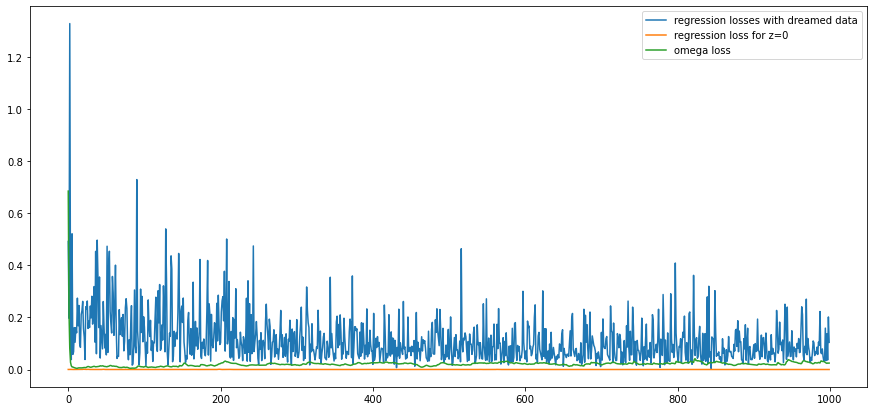

In [12]:
plt.figure(figsize=(15,7))
plt.plot(f_losses, label='regression losses with dreamed data')
plt.plot(f_losses_0, label='regression loss for z=0')
plt.plot(f_losses_omega, label='omega loss')
plt.legend()
plt.show()

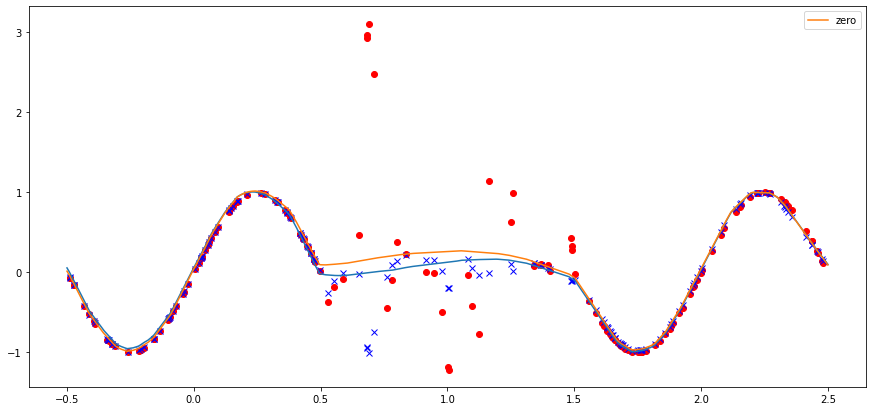

In [20]:
z = torch.randn(NOISE_DIM).to(device=device)

additive_noise = (o_net(full_X)@z).unsqueeze(-1)

plt.figure(figsize=(15, 7))
plt.plot(full_X.cpu(), full_Y.cpu(), 'ro')
residuals = (full_Y - mu(full_X)).abs()
dreamed_data = mu(full_X) + additive_noise * residuals
plt.plot(full_X.cpu(), dreamed_data.detach().cpu(), 'bx')
plt.plot(x_test.cpu(), (f(x_test, z.repeat(x_test.shape[0], 1)) + mu(x_test)).detach().cpu())
plt.plot(x_test.cpu(), (f(x_test) + mu(x_test)).detach().cpu(), label='zero')

plt.legend()
plt.show()

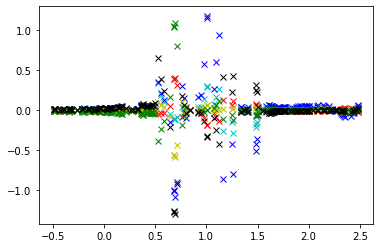

In [21]:
colors = 'rcbygk'
for c in colors:
    z = torch.randn(NOISE_DIM).to(device=device)

    # plt.plot(full_X.cpu(), (o_net(full_X)@z).detach().cpu(), '{}.'.format(c))
    plt.plot(full_X.cpu(), ((o_net(full_X)@z).unsqueeze(-1) * (full_Y - mu(full_X))).detach().cpu(), '{}x'.format(c))

tensor(1.0153)


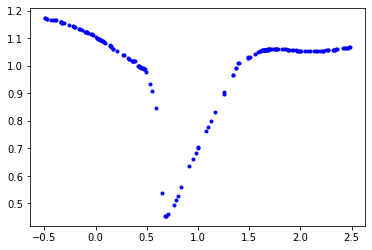

In [22]:
plt.plot(full_X.cpu(), torch.norm(o_net(full_X), dim=1).detach().cpu(), 'b.')
print(torch.norm(o_net(full_X), dim=1).detach().cpu().mean())

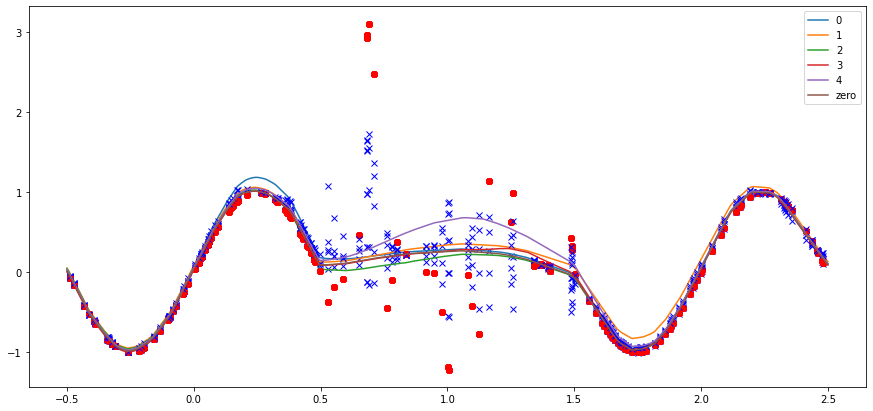

In [26]:
plt.figure(figsize=(15, 7))
for i in range(5):
    z = torch.randn(NOISE_DIM).to(device=device)


    additive_noise = (o_net(full_X)@z).unsqueeze(-1)

    plt.plot(full_X.cpu(), full_Y.cpu(), 'ro')
    residuals = (full_Y - mu(full_X)).abs()
    dreamed_data = mu(full_X) + additive_noise * residuals
    plt.plot(full_X.cpu(), dreamed_data.detach().cpu(), 'bx')
    plt.plot(x_test.cpu(), (mu(x_test) + f(x_test, z.repeat(x_test.shape[0], 1))).detach().cpu(), label=str(i))

plt.plot(x_test.cpu(), (mu(x_test) + f(x_test)).detach().cpu(), label='zero')
plt.legend()
plt.show()

## Learning the bias function

In [52]:
LR3 = 7e-4
EPOCHS3 = 1000
BS3 = 16
loss_fn = nn.MSELoss()

b = main_net(width=512).to(device=device)
optimizer = torch.optim.Adam(b.parameters(), lr=LR3)
f_loader = DataLoader(TensorDataset(full_X, full_Y),
                      shuffle=True,
                      batch_size=BS3)
losses_b = []
for epoch in range(EPOCHS3):
    if epoch % 50 == 0:
        print('epoch {}'.format(epoch))
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(f_loader):
        optimizer.zero_grad()
        with torch.no_grad():
            pred = mu(xi)
        pred_bias = b(xi)
        loss = loss_fn(pred_bias, yi - pred)
        epoch_losses.append(loss.item() * xi.shape[0])
        loss.backward()
        optimizer.step()
    losses_b.append(np.sum(epoch_losses) / x.shape[0])

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
epoch 300
epoch 350
epoch 400
epoch 450
epoch 500
epoch 550
epoch 600
epoch 650
epoch 700
epoch 750
epoch 800
epoch 850
epoch 900
epoch 950


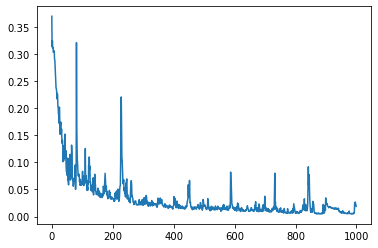

In [53]:
plt.plot(losses_b)
plt.show()

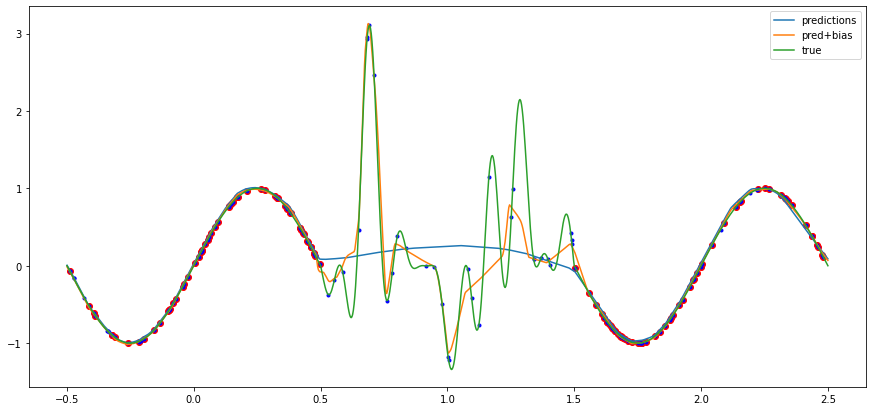

In [54]:
plt.figure(figsize=(15, 7))
plt.plot(x.cpu(), y.cpu(), 'ro')
plt.plot(full_X.cpu(), full_Y.cpu(), 'b.')
plt.plot(x_test.cpu(), mu(x_test).detach().cpu(), label='predictions')
plt.plot(x_test.cpu(), (mu(x_test) + b(x_test)).detach().cpu(), label='pred+bias')
plt.plot(x_test.cpu(), y_test.cpu(), label='true')
plt.legend()
plt.show()